

# **Analyse de Séries Temporelles et Modèles Avancés**



In [ ]:
import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import itertools
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import TimeSeriesSplit
import pickle
import scipy.stats as stats
from scipy.stats import boxcox

In [ ]:
files.upload()

## 1. Choix et Exploration du Dataset

- 1.1 Identifier un dataset pertinent pour les séries temporelles

In [ ]:
df = pd.read_excel("AirQualityUCI.xlsx")

In [ ]:
df.head()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9357 non-null   datetime64[ns]
 1   Time           9357 non-null   object        
 2   CO(GT)         9357 non-null   float64       
 3   PT08.S1(CO)    9357 non-null   float64       
 4   NMHC(GT)       9357 non-null   int64         
 5   C6H6(GT)       9357 non-null   float64       
 6   PT08.S2(NMHC)  9357 non-null   float64       
 7   NOx(GT)        9357 non-null   float64       
 8   PT08.S3(NOx)   9357 non-null   float64       
 9   NO2(GT)        9357 non-null   float64       
 10  PT08.S4(NO2)   9357 non-null   float64       
 11  PT08.S5(O3)    9357 non-null   float64       
 12  T              9357 non-null   float64       
 13  RH             9357 non-null   float64       
 14  AH             9357 non-null   float64       
dtypes: datetime64[ns](1),

In [ ]:
dataset = df[['Date', 'PT08.S5(O3)']]
len(dataset)

9357

In [ ]:
dataset=dataset.set_index('Date')
dataset

NameError: name 'pd' is not defined

In [ ]:
dataset=dataset[:1000]

- 1.2 Prétraiter les données : gestion des valeurs manquantes, anomalies, normalisation

#### Gestion des valeurs manquantes :

In [ ]:
dataset.isnull().sum()

,0
PT08.S5(O3),0


#### Gestion des anomalies :

In [ ]:
# Compter les valeurs négatives
negative_values = df[df['PT08.S5(O3)'] < 0]
print(f"Nombre de valeurs négatives dans PT08.S5(O3) : {len(negative_values)}")

Nombre de valeurs négatives dans PT08.S5(O3) : 366


In [ ]:
# Supprimer les magnitudes négatives
dataset = dataset[dataset['PT08.S5(O3)'] >= 0]


In [ ]:
# Compter les valeurs négatives
negative_values = dataset[dataset['PT08.S5(O3)'] < 0]
print(f"Nombre de valeurs négatives dans PT08.S5(O3) : {len(negative_values)}")

Nombre de valeurs négatives dans PT08.S5(O3) : 0


count     973.000000
mean      996.408273
std       368.730803
min       263.000000
25%       741.000000
50%       962.000000
75%      1240.250000
max      2358.500000
Name: PT08.S5(O3), dtype: float64


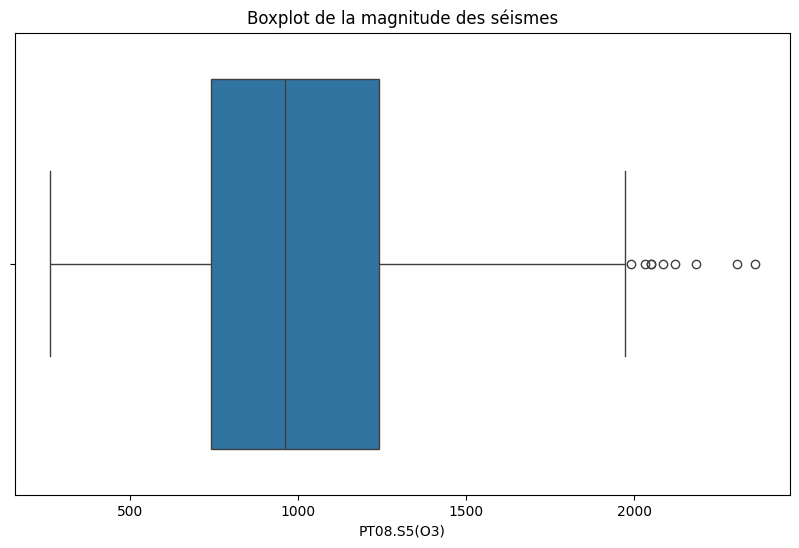

In [ ]:
# Vérification des valeurs aberrantes
print(dataset['PT08.S5(O3)'].describe())

# Visualisation des valeurs aberrantes avec un boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=dataset['PT08.S5(O3)'])
plt.title('Boxplot de PT08.S5(O3)')
plt.show()

Nous pouvons vérifier s'il y a des valeurs aberrantes dans la magnitude. Par exemple, des magnitudes négatives ou extrêmement élevées.

#### Normalisation :

In [ ]:
# Normalisation des données
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(dataset[['PT08.S5(O3)']].values)

La normalisation n'est pas toujours nécessaire pour les séries temporelles, mais si nous décidons de l'utiliser, nous pouvons normaliser la magnitude entre 0 et 1.

In [ ]:
dataset_scaled

- 1.3 Analyse exploratoire (visualisations, tendances, saisonnalités)

#### Visualisation de la série temporelle :

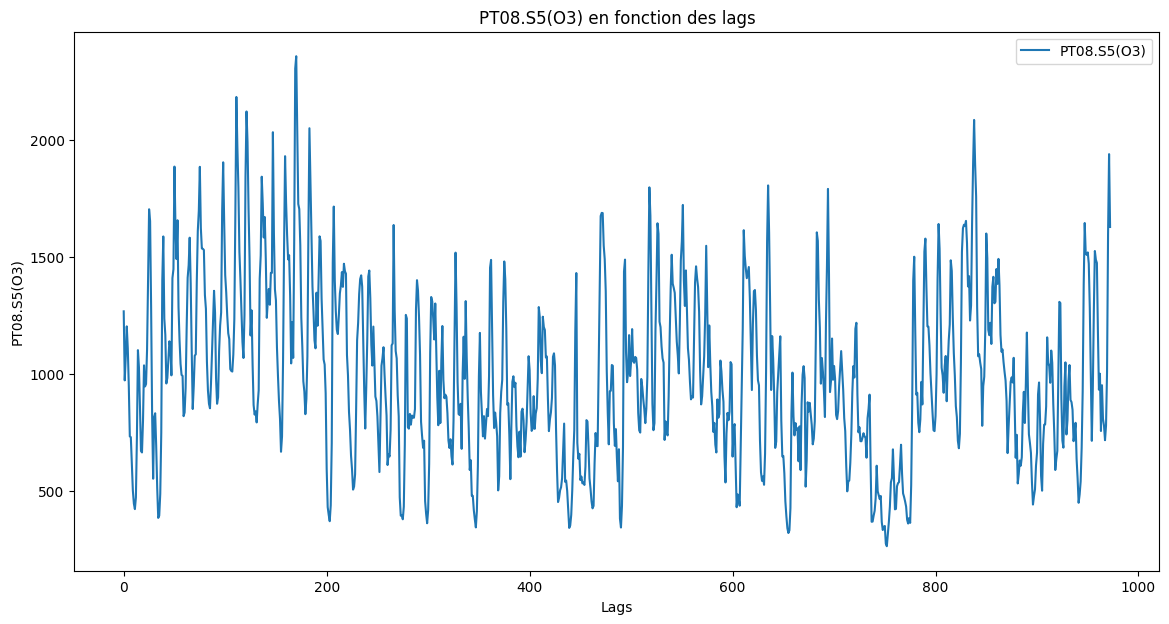

In [ ]:
# Création des lags
lags = np.arange(len(dataset))

# Visualisation de la série temporelle avec les lags
plt.figure(figsize=(14, 7))
plt.plot(lags, dataset['PT08.S5(O3)'], label='PT08.S5(O3)')
plt.title('PT08.S5(O3) en fonction des lags')
plt.xlabel('Lags')
plt.ylabel('PT08.S5(O3)')
plt.legend()
plt.show()




#### Tendances et saisonnalités :

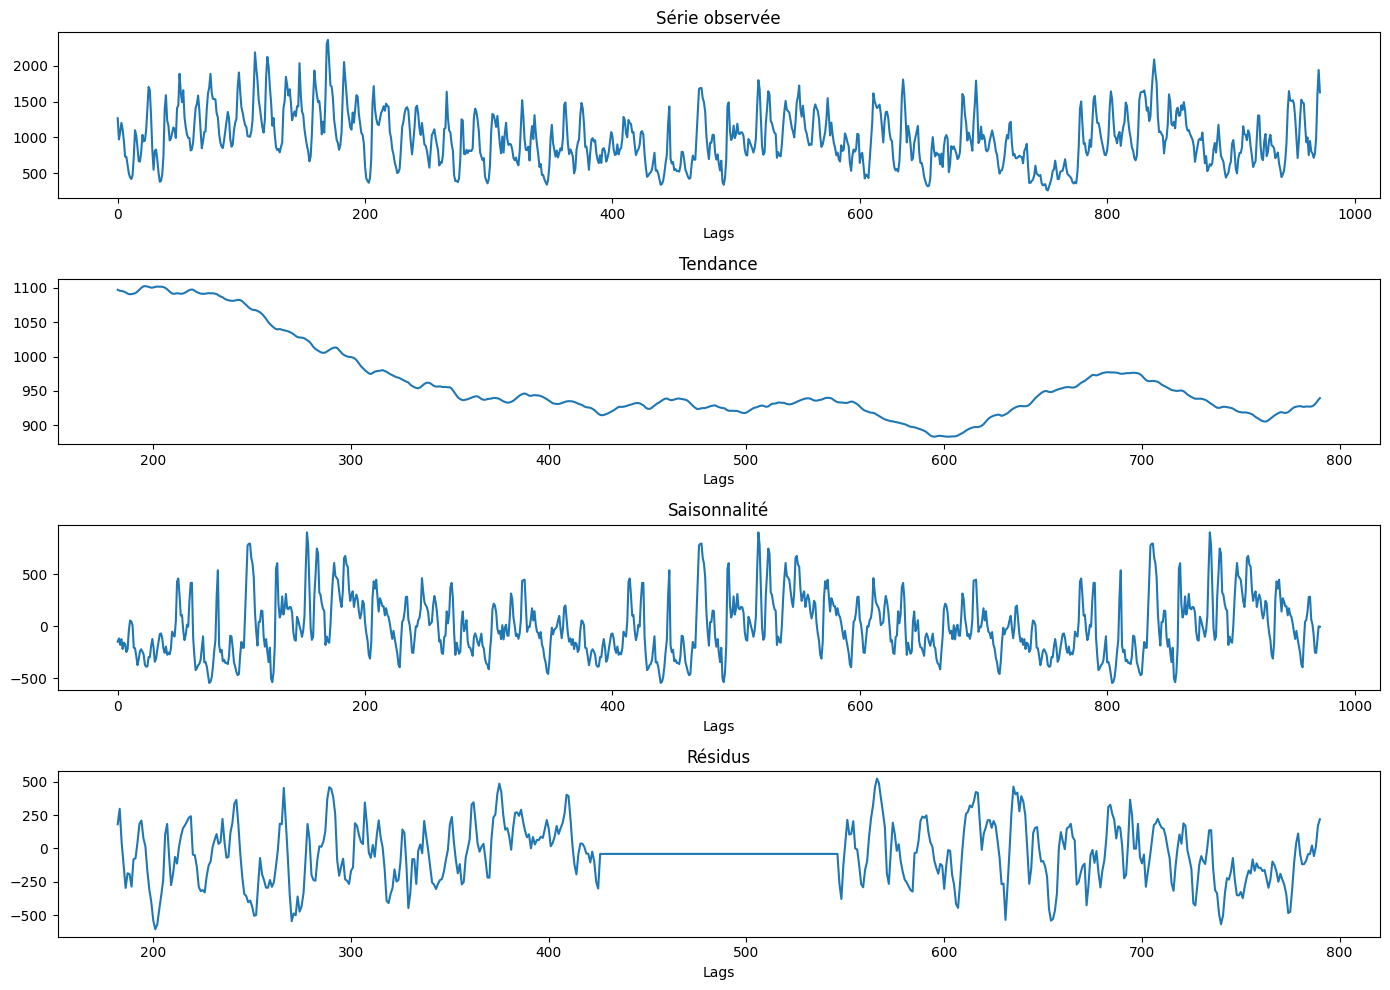

In [ ]:
# Décomposition de la série temporelle
decomposition = seasonal_decompose(dataset['PT08.S5(O3)'], model='additive', period=365)  # Période annuelle

# Visualisation des composantes en fonction des lags
plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(lags, decomposition.observed)
plt.title('Série observée')
plt.xlabel('Lags')

plt.subplot(4, 1, 2)
plt.plot(lags, decomposition.trend)
plt.title('Tendance')
plt.xlabel('Lags')

plt.subplot(4, 1, 3)
plt.plot(lags, decomposition.seasonal)
plt.title('Saisonnalité')
plt.xlabel('Lags')

plt.subplot(4, 1, 4)
plt.plot(lags, decomposition.resid)
plt.title('Résidus')
plt.xlabel('Lags')

plt.tight_layout()
plt.show()

## 2. Modélisation ARIMA

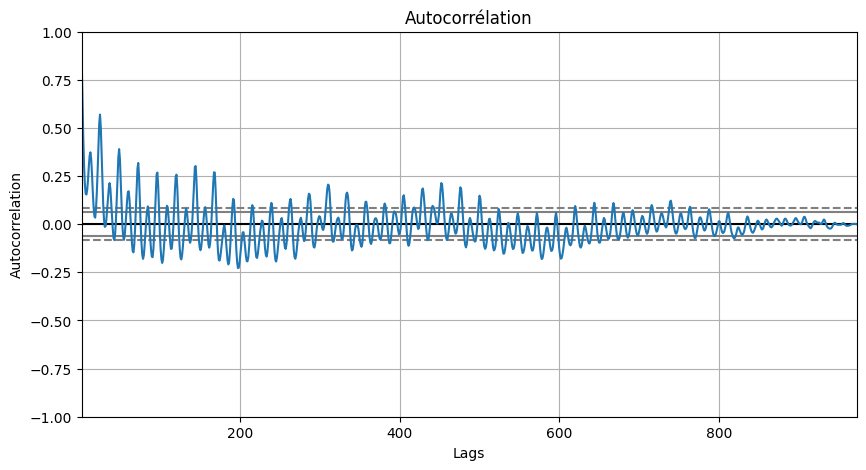

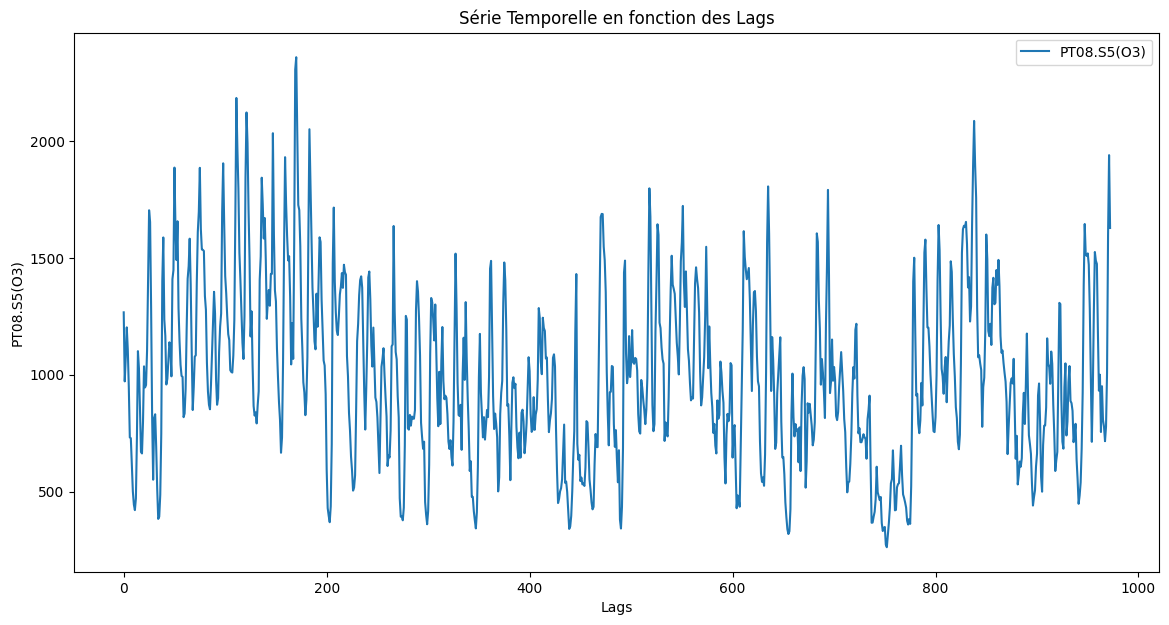

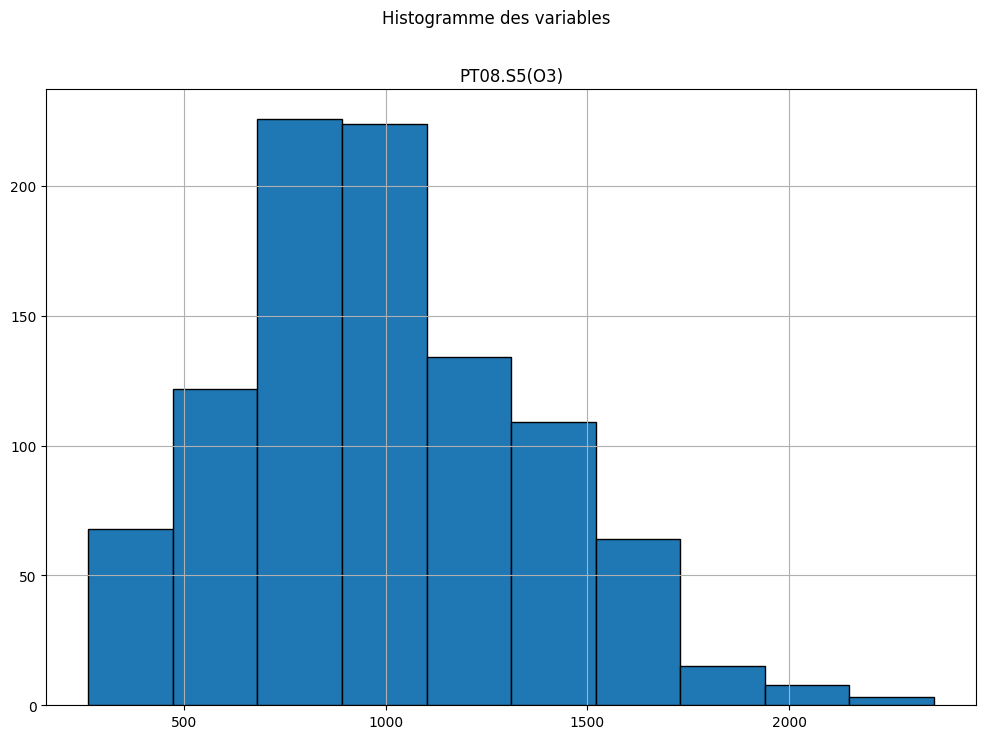

In [ ]:

# Autocorrélation
plt.figure(figsize=(10, 5))
autocorrelation_plot(dataset['PT08.S5(O3)'])
plt.xlabel("Lags")
plt.title("Autocorrélation")
plt.show()

# Line plot en fonction des lags
plt.figure(figsize=(14, 7))
plt.plot(lags, dataset['PT08.S5(O3)'], label='PT08.S5(O3)')
plt.title('Série Temporelle en fonction des Lags')
plt.xlabel('Lags')
plt.ylabel('PT08.S5(O3)')
plt.legend()
plt.show()

# Histogramme (pas besoin de modifier l'axe X ici, car il affiche la distribution)
dataset.hist(edgecolor="black", figsize=(12, 8))
plt.suptitle("Histogramme des variables")
plt.show()

In [ ]:
# Vérifiez la stationnarité avec des tests comme le test ADF

result = adfuller(dataset.dropna())
print("Statistique ADF:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("La série est stationnaire")
else:
    print("La série n'est pas stationnaire")

Statistique ADF: -2.136764743902299
p-value: 0.22999049785710152
La série n'est pas stationnaire


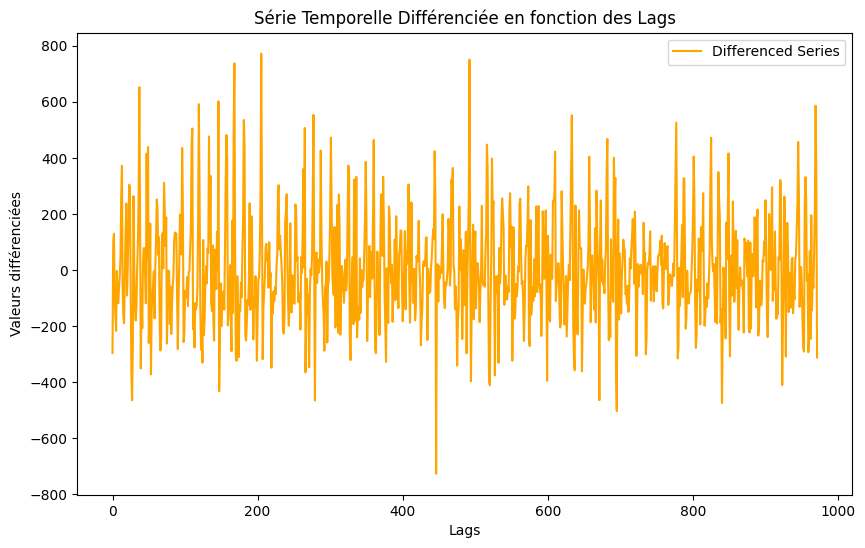

In [ ]:
# Appliquer la différenciation
dataset_diff = dataset.diff().dropna()

# Création des lags (adaptés à la série différenciée)
lags = np.arange(len(dataset_diff))  # Indices 0, 1, 2, ..., n-1 après différenciation

# Tracer la série différenciée en fonction des lags
plt.figure(figsize=(10, 6))
plt.plot(lags, dataset_diff, label='Differenced Series', color='orange')
plt.title('Série Temporelle Différenciée en fonction des Lags')
plt.xlabel('Lags')
plt.ylabel('Valeurs différenciées')
plt.legend()
plt.show()

In [ ]:
result = adfuller(dataset_diff.dropna())
print("Statistique ADF:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("La série est stationnaire")
else:
    print("La série n'est pas stationnaire")

Statistique ADF: -13.158733037908748
p-value: 1.3207235767390321e-24
La série est stationnaire


<Figure size 1000x600 with 0 Axes>

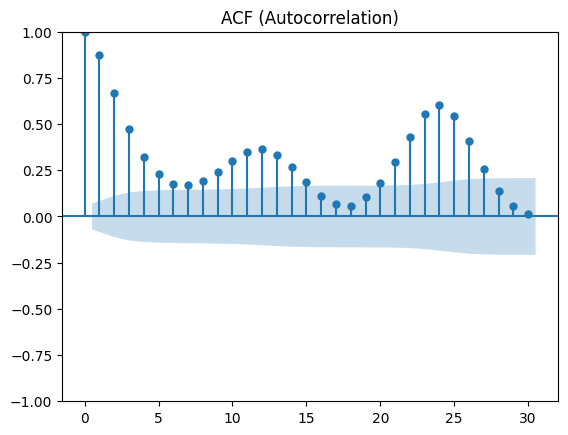

<Figure size 1000x600 with 0 Axes>

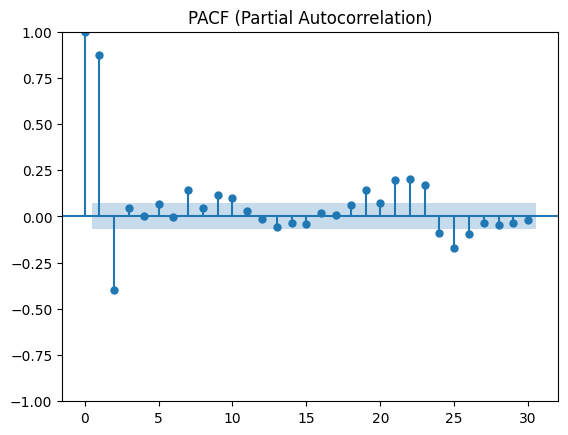

In [ ]:
# Division des données en ensembles d'entraînement et de test
train_size = int(len(dataset) * 0.8)  # 80% entraînement, 20% test
train, test = dataset.iloc[:train_size], dataset.iloc[train_size:]
# Tracez les graphiques ACF et PACF pour estimer les paramètres initiaux
# ACF et PACF pour ajuster les paramètres ARIMA
plt.figure(figsize=(10, 6))
plot_acf(train, lags=30, title="ACF (Autocorrelation)")
plt.show()

plt.figure(figsize=(10, 6))
plot_pacf(train, lags=30, title="PACF (Partial Autocorrelation)")
plt.show()

In [ ]:
# Recherche par grille pour les paramètres ARIMA
# Effectuez une recherche par grille sur (p, d, q) pour minimiser le critère AIC

def grid_search_arima(train, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(train, order=(p, d, q))
            model_fit = model.fit()
            aic = model_fit.aic
            if aic < best_score:
                best_score, best_cfg = aic, (p, d, q)
        except:
            continue
    return best_cfg, best_score

In [ ]:
# Définir les plages pour p, d, q
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

best_cfg, best_score = grid_search_arima(train['PT08.S5(O3)'], p_values, d_values, q_values)
print(f"Meilleurs paramètres ARIMA: {best_cfg} avec AIC: {best_score}")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Meilleurs paramètres ARIMA: (2, 1, 1) avec AIC: 10148.82455282591


In [ ]:
# Validation par glissement (Walk Forward Validation)
history = list(train['PT08.S5(O3)'])
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=best_cfg)  # Utilisation des paramètres optimisés
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test['PT08.S5(O3)'].iloc[t])  # Mise à jour avec la vraie valeur

In [ ]:
# Calcul des métriques
residuals = test['PT08.S5(O3)'].values - np.array(predictions)
residual_forecast_error = np.mean(residuals)
forecast_bias = residual_forecast_error
mae_arima = mean_absolute_error(test['PT08.S5(O3)'], predictions)
mse_arima = mean_squared_error(test['PT08.S5(O3)'], predictions)
rmse_arima = np.sqrt(mse_arima)
r2_arima = r2_score(test['PT08.S5(O3)'], predictions)



print(f"Residual Forecast Error: {residual_forecast_error}")
print(f"Forecast Bias: {forecast_bias}")
print(f"Mean Absolute Error: {mae_arima}")
print(f"Mean Squared Error: {mse_arima}")
print(f"Root Mean Squared Error: {rmse_arima}")
print(f"R² Score: {r2_arima}")

Residual Forecast Error: 16.099592752419454
Forecast Bias: 16.099592752419454
Mean Absolute Error: 123.4096448698548
Mean Squared Error: 24965.311545484074
Root Mean Squared Error: 158.00415040588038
R² Score: 0.7819570341404055


In [ ]:
# Modèle de persistance (Baseline)
persistence_predictions = test['PT08.S5(O3)'].shift(1).dropna()
test_persistence = test['PT08.S5(O3)'][1:]
mse_baseline = mean_squared_error(test_persistence, persistence_predictions)
rmse_baseline = np.sqrt(mse_baseline)
print(f"Persistence Model RMSE: {rmse_baseline}")

Persistence Model RMSE: 177.88654629673138


In [ ]:
# Définir les plages pour ARIMA
train_range = range(len(train))  # Plage pour les données d'entraînement
test_range = range(len(train), len(train) + len(test))  # Plage pour les données de test
pred_range = range(len(train), len(train) + len(predictions))  # Plage pour les prédictions

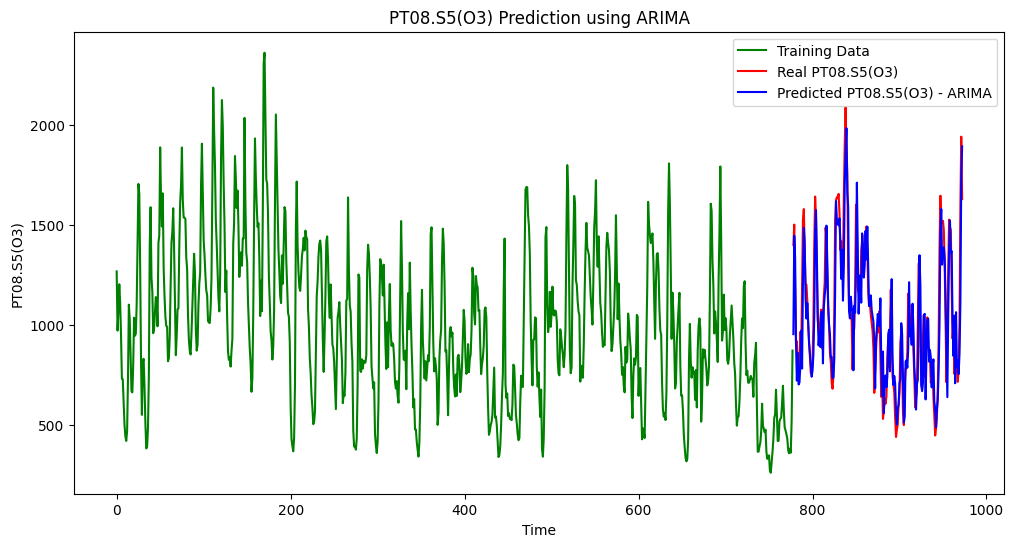

In [ ]:
# Visualisation des prédictions ARIMA vs valeurs réelles
plt.figure(figsize=(12, 6))
plt.plot(train_range, train['PT08.S5(O3)'], color='green', label='Training Data')  # Données d'entraînement
plt.plot(test_range, test['PT08.S5(O3)'], color='red', label='Real PT08.S5(O3)')  # Données réelles (test)
plt.plot(pred_range, predictions, color='blue', label='Predicted PT08.S5(O3) - ARIMA')  # Prédictions ARIMA
plt.title('PT08.S5(O3) Prediction using ARIMA')
plt.xlabel('Time')
plt.ylabel('PT08.S5(O3)')
plt.legend()
plt.show()

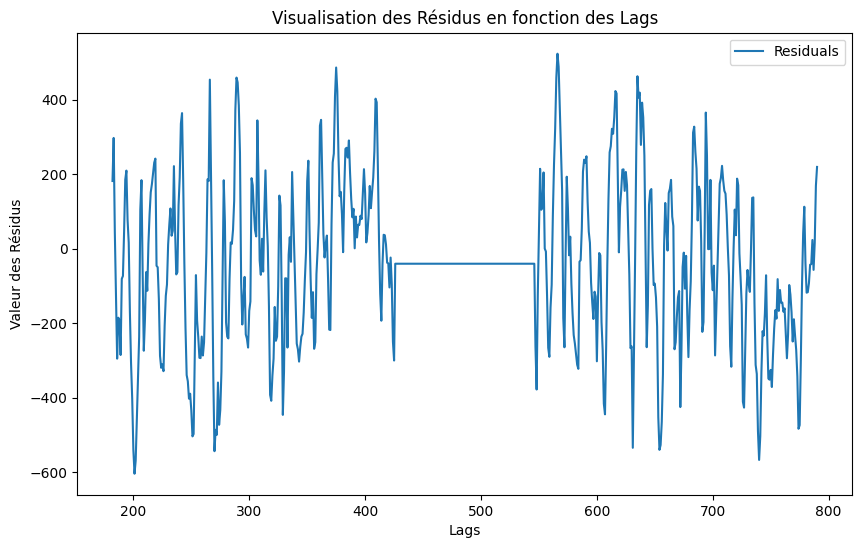

In [ ]:
lags_dec = np.arange(len(decomposition.resid))

# Visualisation des résidus en fonction des lags
plt.figure(figsize=(10, 6))
plt.plot(lags_dec, decomposition.resid[:len(lags_dec)], label="Residuals")
plt.title("Visualisation des Résidus en fonction des Lags")
plt.xlabel("Lags")
plt.ylabel("Valeur des Résidus")
plt.legend()
plt.show()

In [ ]:
# Résumé des statistiques des résidus
print("\nResidual Summary Statistics:")
print(pd.Series(decomposition.resid).describe())


Residual Summary Statistics:
count    609.000000
mean     -40.602223
std      205.465813
min     -604.550967
25%     -167.106675
50%      -40.602223
75%       85.902229
max      523.346521
Name: resid, dtype: float64


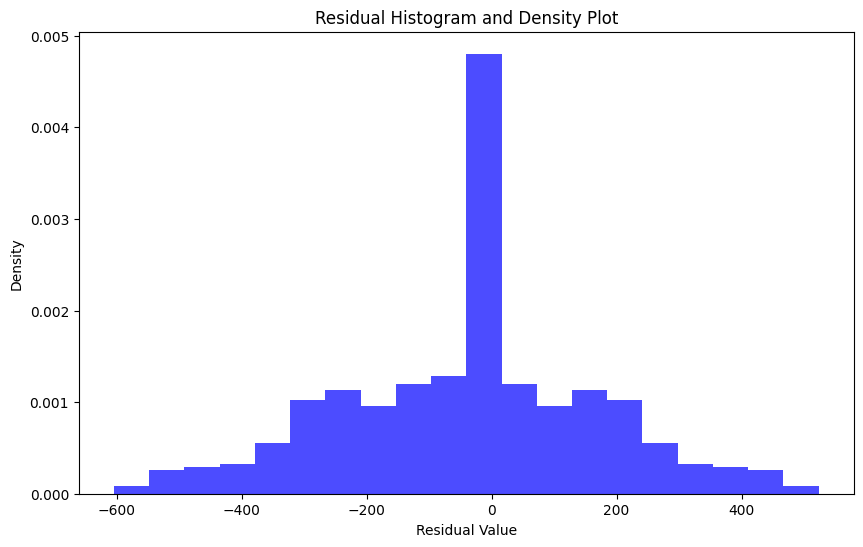

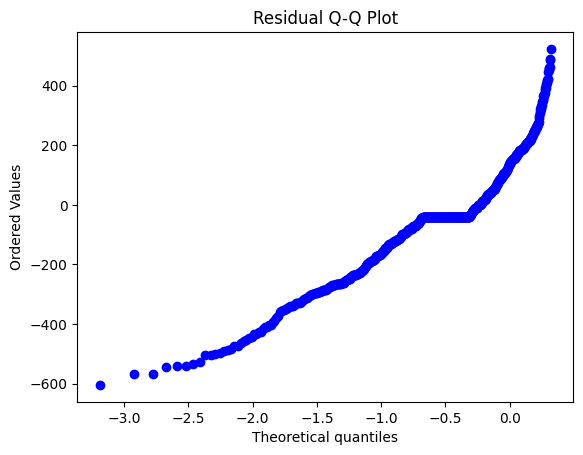

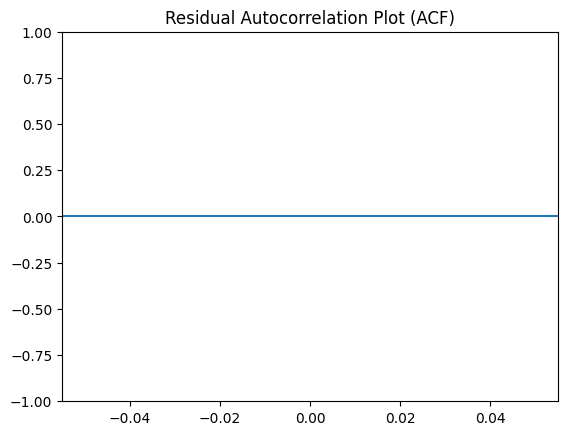

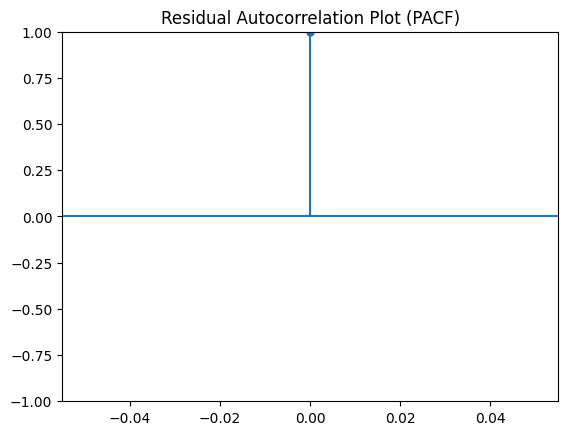

In [ ]:
# Histogramme et densité des résidus
plt.figure(figsize=(10, 6))
plt.hist(decomposition.resid, bins=20, alpha=0.7, color="blue", density=True)
plt.title("Residual Histogram and Density Plot")
plt.xlabel("Residual Value")
plt.ylabel("Density")
plt.show()

# Q-Q Plot des résidus
stats.probplot(decomposition.resid, dist="norm", plot=plt)
plt.title("Residual Q-Q Plot")
plt.show()

# Autocorrélation des résidus
plot_acf(decomposition.resid, lags=20)
plt.title("Residual Autocorrelation Plot (ACF)")
plt.show()
# Autocorrélation des résidus
plot_pacf(decomposition.resid, lags=20)
plt.title("Residual Autocorrelation Plot (PACF)")
plt.show()

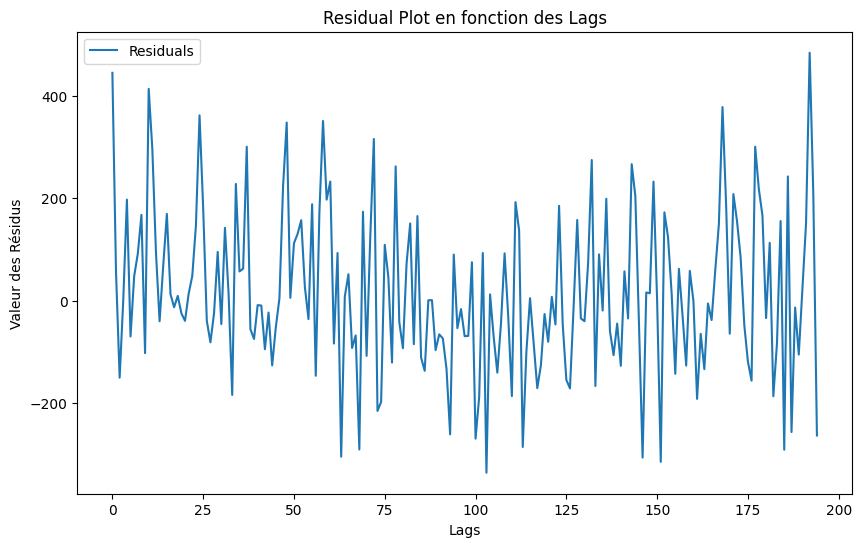

In [ ]:
residuals = test['PT08.S5(O3)'] - predictions

lags_residuals = np.arange(len(residuals))  # Indices [0, 1, 2, ..., n-1]

# Visualisation des résidus en fonction des lags
plt.figure(figsize=(10, 6))
plt.plot(lags_residuals, residuals, label="Residuals")
plt.title("Residual Plot en fonction des Lags")
plt.xlabel("Lags")
plt.ylabel("Valeur des Résidus")
plt.legend()
plt.show()



## 3. Modélisation avec Deep Learning

### 3.1 RNN (Recurrent Neural Networks)

Préparation des fenêtres temporelles pour l'entraînement

In [ ]:
# Préparation des séquences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Augmentation des données
def add_noise(data, noise_level=0.01):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

Division de données en ensembles d'entraînement et de test

In [ ]:
# Hyperparamètres
seq_length = 60
lr = 0.001
unit = 150
dropout = 0.3
n_epochs = 150
batch_size = 64

In [ ]:
# Création des séquences
X, y = create_sequences(dataset_scaled, seq_length)
X_noisy, y_noisy = create_sequences(add_noise(dataset_scaled), seq_length)

Construction du modèle RNN

In [ ]:
# Reshape des données pour RNN
X = np.concatenate((X, X_noisy))
y = np.concatenate((y, y_noisy))
X = X.reshape((X.shape[0], X.shape[1], 1))

Entraînement du modèle

In [ ]:
# Division en ensembles d'entraînement et de test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# Construction du modèle RNN
regressor_rnn = Sequential()

# Première couche RNN avec Dropout
regressor_rnn.add(SimpleRNN(units=unit, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor_rnn.add(Dropout(dropout))

# Deuxième couche RNN avec Dropout
regressor_rnn.add(SimpleRNN(units=unit, return_sequences=True))
regressor_rnn.add(Dropout(dropout))

# Troisième couche RNN avec Dropout
regressor_rnn.add(SimpleRNN(units=unit))
regressor_rnn.add(Dropout(dropout))

# Couche de sortie
regressor_rnn.add(Dense(units=1))

# Compilation du modèle
optimizer = Adam(learning_rate=lr)
regressor_rnn.compile(optimizer=optimizer, loss='mean_squared_error')

# Entraînement du modèle
regressor_rnn.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size)

In [ ]:
# Sauvegarde du modèle
filename = 'regressor_rnn_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(regressor_rnn, file)

from google.colab import files

# Téléchargement du fichier
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
with open('regressor_rnn_model.pkl', 'rb') as file:
    regressor_rnn = pickle.load(file)

In [ ]:
# Prédiction
y_predicted_rnn = regressor_rnn.predict(X_test)
y_predicted_rnn = scaler.inverse_transform(y_predicted_rnn.reshape(-1, 1))
y_real_rnn = scaler.inverse_transform(y_test.reshape(-1, 1))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


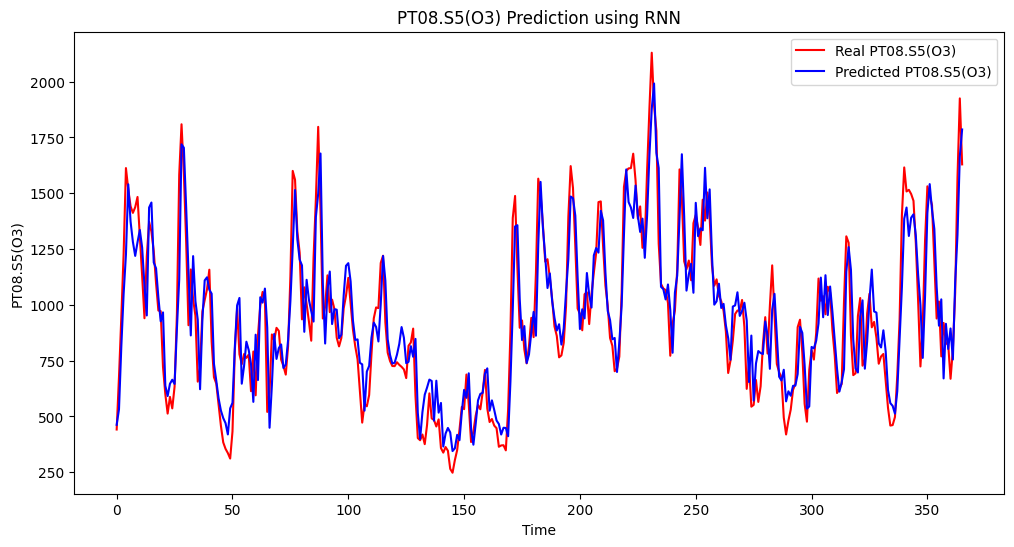

In [ ]:
# Visualisation des résultats
plt.figure(figsize=(12, 6))
plt.plot(y_real_rnn, color='red', label='Real PT08.S5(O3)')
plt.plot(y_predicted_rnn, color='blue', label='Predicted PT08.S5(O3)')
plt.title('PT08.S5(O3) Prediction using RNN')
plt.xlabel('Time')
plt.ylabel('PT08.S5(O3)')
plt.legend()
plt.show()

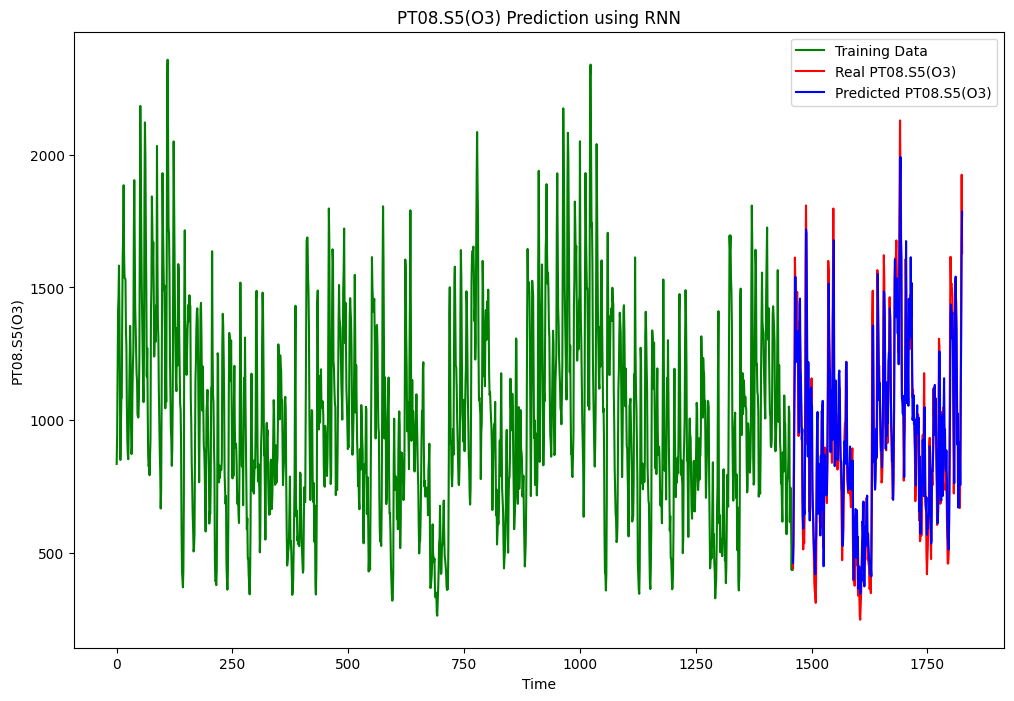

In [ ]:
# Visualisation de l'entraînement, des prédictions et des tests
train_range = range(len(y_train))
test_range = range(len(y_train), len(y_train) + len(y_real))
pred_range = range(len(y_train), len(y_train) + len(y_predicted))

plt.figure(figsize=(12, 8))
plt.plot(train_range, scaler.inverse_transform(y_train.reshape(-1, 1)), color='green', label='Training Data')
plt.plot(test_range, y_real_rnn, color='red', label='Real PT08.S5(O3)')
plt.plot(pred_range, y_predicted_rnn, color='blue', label='Predicted PT08.S5(O3)')
plt.title('PT08.S5(O3) Prediction using RNN')
plt.xlabel('Time')
plt.ylabel('PT08.S5(O3)')
plt.legend()
plt.show()

In [ ]:
# Évaluation du modèle
print("Evaluation du modèle:")
mse_rnn = mean_squared_error(y_real_rnn, y_predicted_rnn)
rmse_rnn = np.sqrt(mse_rnn)
mae_rnn = mean_absolute_error(y_real_rnn, y_predicted_rnn)
r2_rnn = r2_score(y_real_rnn, y_predicted_rnn)

print(f"Mean Squared Error (MSE): {mse_rnn}")
print(f"Mean Absolute Error (MAE): {mae_rnn}")
print(f"R² Score: {r2_rnn}")

Evaluation du modèle:
Mean Squared Error (MSE): 19888.14932535974
Mean Absolute Error (MAE): 111.59860953326151
R² Score: 0.8460504789003471


### 3.2 LSTM (Long Short-Term Memory)

#### Préparation des séquences .

In [ ]:
# Création des séquences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

#### Augmentation des données

In [ ]:
# Augmentation de données : ajout de bruit
def add_noise(data, noise_level=0.01):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

In [ ]:
# Création des séquences avec données augmentées
seq_length = 60
X, y = create_sequences(dataset_scaled, seq_length)
X_noisy, y_noisy = create_sequences(add_noise(dataset_scaled), seq_length)

In [ ]:
# Reshape des données pour LSTM [samples, time steps, features]
X = np.concatenate((X, X_noisy))
y = np.concatenate((y, y_noisy))
# Reshape des données pour LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

In [ ]:
# Division en ensembles d'entraînement et de test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

#### Hyperparamètres

In [ ]:
seq_length = 60
train_size = int(len(X) * 0.8)
lr=0.001
unit=150
dropout=0.3
n_epochs = 150
batch_size = 64

#### Proposition d’architecture :

- Couches adaptées pour LSTM avec empilement si nécessaire :

Nous allons utiliser plusieurs couches LSTM empilées pour capturer les dépendances temporelles complexes dans les données.

Chaque couche LSTM sera suivie d'une couche de Dropout pour éviter le surapprentissage (overfitting).

La dernière couche sera une couche Dense pour produire la sortie (prédiction de la magnitude).

- Régularisation et ajustement des flux d'information entre les couches :

Le Dropout est utilisé pour désactiver aléatoirement une fraction des neurones pendant l'entraînement, ce qui aide à prévenir le surapprentissage.

Le taux de Dropout est fixé à 0.3, ce qui signifie que 30 % des neurones seront désactivés à chaque étape d'entraînement.

In [ ]:
# 2. Construction du modèle LSTM

regressor_lstm = Sequential()

# Première couche LSTM avec Dropout
regressor_lstm.add(LSTM(units=unit, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor_lstm.add(Dropout(dropout))

# Deuxième couche LSTM avec Dropout
regressor_lstm.add(LSTM(units=unit, return_sequences=True))
regressor_lstm.add(Dropout(dropout))

# Troisième couche LSTM avec Dropout
regressor_lstm.add(LSTM(units=unit))
regressor_lstm.add(Dropout(dropout))

# Couche de sortie
regressor_lstm.add(Dense(units=1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Optimiseur avec un taux d'apprentissage plus faible
optimizer = Adam(learning_rate=lr)
regressor_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

In [ ]:
# Entraînement du modèle
regressor_lstm.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size)

In [ ]:
# Sauvegarder le modèle
filename = 'regressor_lstm_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(regressor_lstm, file)

from google.colab import files

# Télécharger le fichier
files.download(filename)



In [ ]:
# Load the LSTM model
with open('regressor_lstm_model.pkl', 'rb') as file:
    regressor_lstm = pickle.load(file)

In [ ]:
# 4. Prédiction
y_predicted = regressor_lstm.predict(X_test)
y_predicted = scaler.inverse_transform(y_predicted)  # Transformation inverse pour obtenir les valeurs réelles
y_real = scaler.inverse_transform(y_test.reshape(-1, 1))  # Transformation inverse pour les valeurs réelles


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step


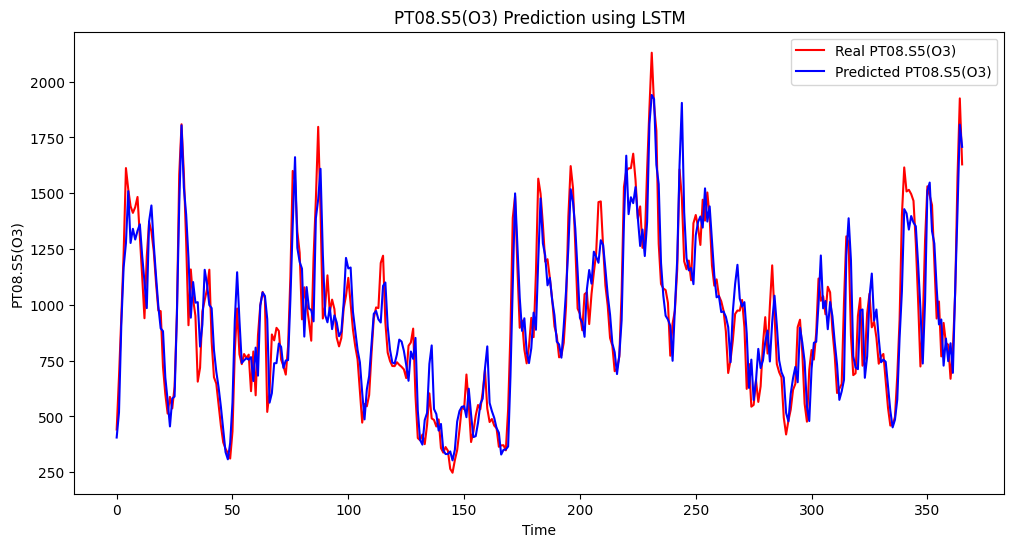

In [ ]:
# 5. Visualisation des résultats
plt.figure(figsize=(12, 6))
plt.plot(y_real, color='red', label='Real PT08.S5(O3)')
plt.plot(y_predicted, color='blue', label='Predicted PT08.S5(O3)')
plt.title('PT08.S5(O3) Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('PT08.S5(O3)')
plt.legend()
plt.show()

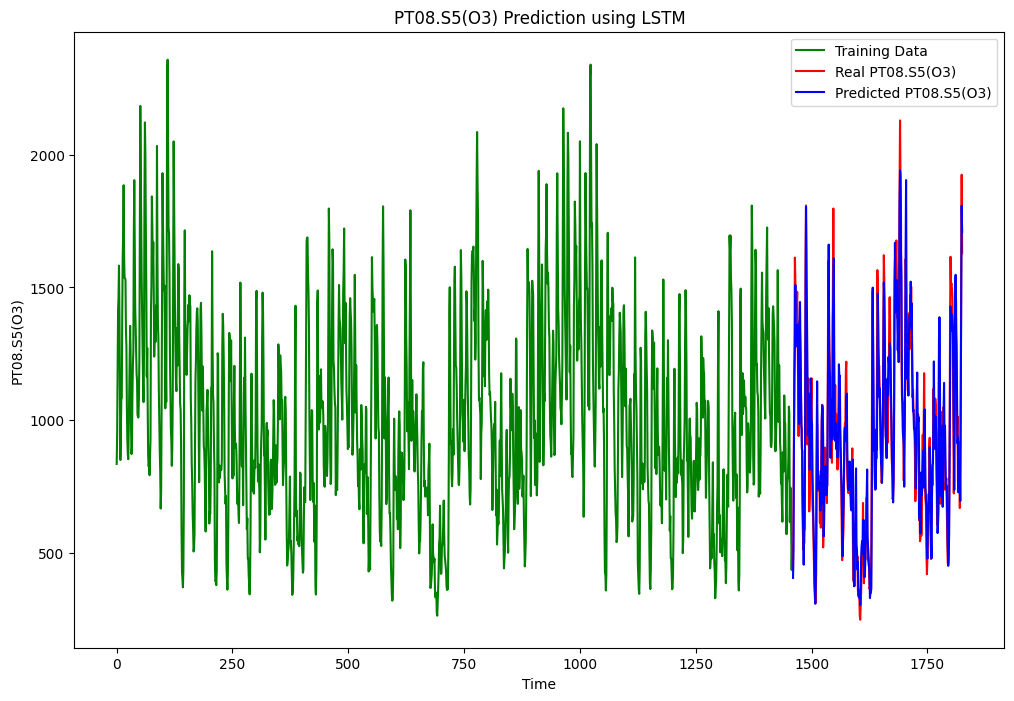

In [ ]:
# 6. Visualisation de l'entraînement, des prédictions et des tests
train_range = range(len(y_train))
test_range = range(len(y_train), len(y_train) + len(y_real))
pred_range = range(len(y_train), len(y_train) + len(y_predicted))

plt.figure(figsize=(12, 8))
plt.plot(train_range, scaler.inverse_transform(y_train.reshape(-1, 1)), color='green', label='Training Data')
plt.plot(test_range, y_real, color='red', label='Real PT08.S5(O3)')
plt.plot(pred_range, y_predicted, color='blue', label='Predicted PT08.S5(O3)')
plt.title('PT08.S5(O3) Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('PT08.S5(O3)')
plt.legend()
plt.show()

In [ ]:
# 7. Évaluation du modèle
print("Evaluation du modèle:")
mse_lstm = mean_squared_error(y_real, y_predicted)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_real, y_predicted)
r2_lstm = r2_score(y_real, y_predicted)

print(f"Mean Squared Error (MSE): {mse_lstm}")
print(f"Mean Absolute Error (MAE): {mae_lstm}")
print(f"R² Score: {r2_lstm}")

Evaluation du modèle:
Mean Squared Error (MSE): 17572.524961459403
Mean Absolute Error (MAE): 102.97603910010308
R² Score: 0.8639751865258364


### 3.3 Comparaison des différentes techniques

In [ ]:
# Supposons que vous avez déjà calculé mae_sqrt, mse_sqrt, rmse_sqrt

performance = pd.DataFrame({
    "Model": ["ARIMA","RNN", "LSTM"],
    "MAE": [mae_arima,mae_rnn, mae_lstm],
    "MSE": [mse_arima,mse_rnn, mse_lstm],
    "RMSE": [rmse_arima,rmse_rnn, rmse_lstm],
    "R2": [r2_arima,r2_rnn, r2_lstm]
})
performance.set_index("Model", inplace=True)
print(performance)


              MAE           MSE        RMSE        R2
Model                                                
ARIMA  123.409645  24965.311545  158.004150  0.781957
RNN    115.913238  21282.121348  145.883931  0.835376
LSTM   102.976039  17572.524961  132.561401  0.863975


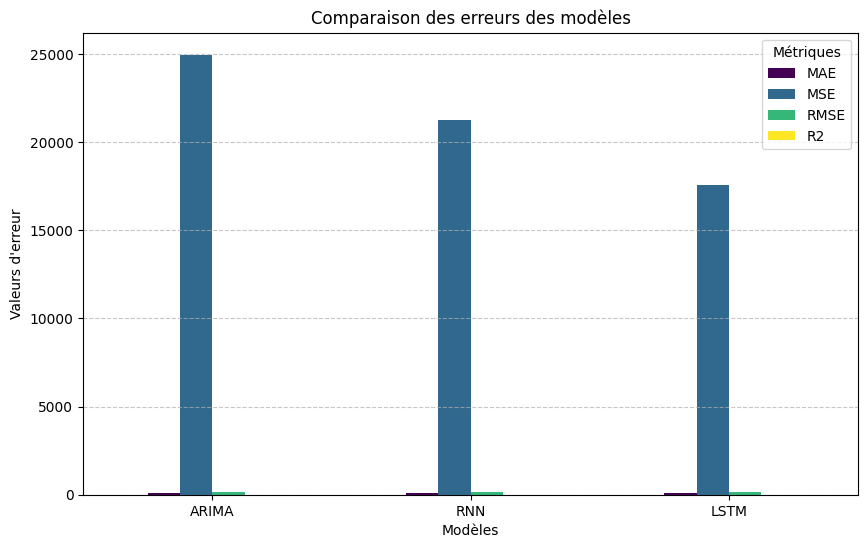

In [ ]:
# Tracer le graphique en barres
performance["R2"].plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Comparaison des erreurs des modèles")
plt.ylabel("Valeurs d'erreur")
plt.xlabel("Modèles")
plt.xticks(rotation=0)
plt.legend(title="Métriques")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

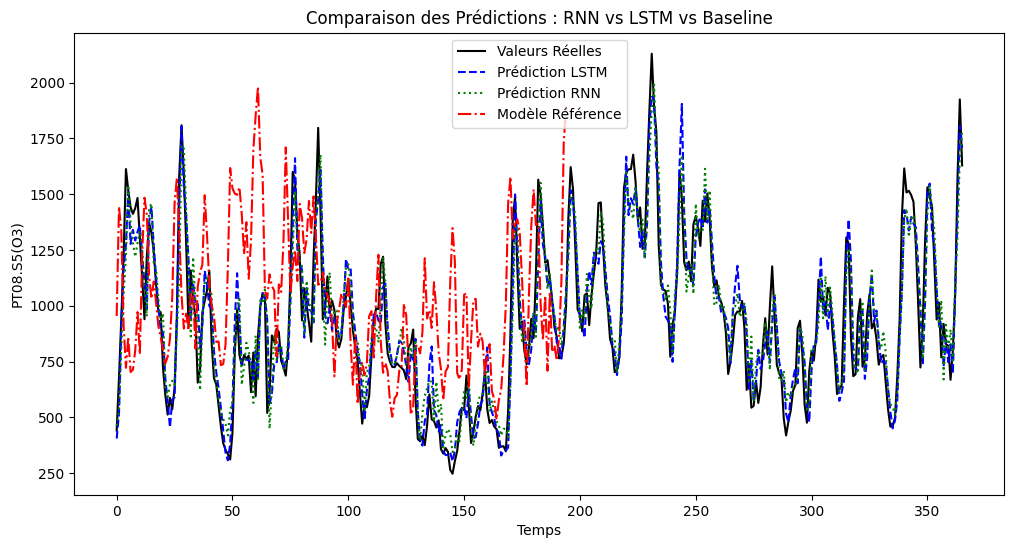

In [ ]:
plt.figure(figsize=(12, 6))

# Valeurs réelles
plt.plot(y_real, color='black', label='Valeurs Réelles')

# Prédictions LSTM
plt.plot(y_predicted, color='blue', linestyle='dashed', label='Prédiction LSTM')

# Prédictions RNN
plt.plot(y_predicted_rnn, color='green', linestyle='dotted', label='Prédiction RNN')

# Prédictions Modèle de référence
plt.plot(predictions, color='red', linestyle='dashdot', label='Modèle Référence')

plt.title('Comparaison des Prédictions : RNN vs LSTM vs Baseline')
plt.xlabel('Temps')
plt.ylabel('PT08.S5(O3)')
plt.legend()
plt.show()


# FIN